In [ ]:
import subprocess
import sys

# INSTALL REQUIRED PACKAGES
packages = ['yfinance', 'ta', 'backtrader']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import backtrader as bt
import matplotlib.dates as mdates
import re

# SETUP MATPLOTLIB FOR CHINESE SUPPORT
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


ticker = 'MSFT'
start_date = '2014-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [26]:

print(" DATA CLEANING AND PREPROCESSING")

# Flatten and rename columns
data_flat = data.copy()
data_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_flat.columns]
data_flat = data_flat.reset_index()
data_flat = data_flat.rename(columns={
    'Open_MSFT': 'open',
    'High_MSFT': 'high',
    'Low_MSFT': 'low',
    'Close_MSFT': 'close',
    'Volume_MSFT': 'volume'
})


 DATA CLEANING AND PREPROCESSING


In [ ]:

 # ==================== Parameterized Strategy Base ====================
class ParameterizedMAStrategy(bt.Strategy):
    """
    Unified parameterized moving-average strategy.
    Supports different SMA periods and optional trend filter.
    """
    params = (
        ('sma_short', 10),      # Short SMA period
        ('sma_long', 30),       # Long SMA period
        ('sma_trend', 200),     # Trend filter SMA period (None = disabled)
        ('rsi_period', 14),     # RSI period
        ('use_trend_filter', False),  # Whether to use trend filter
        ('volume_period', 5),   # Volume SMA period
        ('capital', 100000),    # Initial capital
    )

    def __init__(self):
        # Moving averages
        self.sma_short = bt.indicators.SMA(self.data.close, period=self.params.sma_short)
        self.sma_long = bt.indicators.SMA(self.data.close, period=self.params.sma_long)
        
        # Optional trend filter SMA
        if self.params.use_trend_filter and self.params.sma_trend:
            self.sma_trend = bt.indicators.SMA(self.data.close, period=self.params.sma_trend)
        else:
            self.sma_trend = None
        
        # Momentum indicator
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        
        # Volume indicator
        self.volume_sma = bt.indicators.SMA(self.data.volume, period=self.params.volume_period)
        
        # Additional indicators (kept for extension)
        self.ema = bt.indicators.EMA(self.data.close, period=self.params.sma_long)
        self.macd = bt.indicators.MACD(self.data.close)
        self.bb = bt.indicators.BollingerBands(self.data.close)
        
        # Trade state management
        self.trades = []
        self.in_position = False

    def next(self):
        # Trend filter: price above trend SMA if enabled
        trend_filter = True
        if self.sma_trend is not None:
            trend_filter = self.data.close[0] > self.sma_trend[0]
        
        # Buy condition
        if not self.in_position:
            # Condition 1: Short SMA crosses above long SMA (golden cross)
            golden_cross = (self.sma_short[0] > self.sma_long[0] and 
                           self.sma_short[-1] <= self.sma_long[-1])
            
            # Condition 2: Volume confirmation (current volume > SMA volume)
            volume_confirm = self.data.volume[0] > self.volume_sma[0]
            
            # Condition 3: RSI in 30-70 range
            rsi_confirm = 30 <= self.rsi[0] <= 70
            
            if golden_cross and volume_confirm and rsi_confirm and trend_filter:
                size = int(self.params.capital / self.data.close[0])
                self.buy(size=size)
                self.in_position = True
                self.trades.append(('buy', self.data.datetime.date(), size, 'golden_cross'))
        
        # Sell condition
        elif self.in_position:
            # Condition 1: Short SMA crosses below long SMA (death cross)
            death_cross = (self.sma_short[0] < self.sma_long[0] and 
                          self.sma_short[-1] >= self.sma_long[-1])
            
            # Condition 2: RSI > 80 (overbought)
            rsi_overbought = self.rsi[0] > 80
            
            # Condition 3: Break below trend SMA (if enabled)
            trend_reversal = False
            if self.sma_trend is not None:
                trend_reversal = self.data.close[0] < self.sma_trend[0]
            
            if death_cross or rsi_overbought or (trend_reversal and self.sma_trend is not None):
                reason = 'death_cross'
                if rsi_overbought:
                    reason = 'rsi_overbought'
                elif trend_reversal:
                    reason = 'trend_reversal'
                
                self.sell(size=self.position.size)
                self.in_position = False
                self.trades.append(('sell', self.data.datetime.date(), self.position.size, reason))


 # ==================== Unified Backtest Runner ====================
def run_backtest(strategy_params, strategy_name, strategy_class=ParameterizedMAStrategy):
    """
    Unified function to run backtests.
    """
    print(f"\n{'='*80}")
    print(f"🚀 {strategy_name}")
    print(f"{'='*80}")
    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class, **strategy_params)
    
    data_feed = bt.feeds.PandasData(dataname=data_flat[['Date', 'open', 'high', 'low', 'close', 'volume']].set_index('Date'))
    cerebro.adddata(data_feed)
    
    cerebro.broker.setcommission(commission=0.001)  # 0.1% commission
    cerebro.broker.setcash(strategy_params.get('capital', 100000))
    
    initial_cash = cerebro.broker.getcash()
    print(f"Initial portfolio value: ${initial_cash:,.2f}")
    
    strategy_result = cerebro.run()
    strategy = strategy_result[0]
    
    final_value = cerebro.broker.getvalue()
    total_return = (final_value - initial_cash) / initial_cash * 100
    
    print(f"Final portfolio value: ${final_value:,.2f}")
    print(f"Total return: {total_return:.2f}%")
    
    # Handle different trade log attributes
    trades_log = strategy.trades if hasattr(strategy, 'trades') else strategy.trades_log
    print(f"Number of trades: {len(trades_log)}")
    
    results_dict = {
        'strategy_name': strategy_name,
        'initial_cash': initial_cash,
        'final_value': final_value,
        'total_return': total_return,
        'trades': trades_log,
        'cerebro': cerebro,
        'strategy': strategy
    }
    
    return cerebro, strategy, results_dict


 # ==================== Unified Trade Analysis ====================
def analyze_trades(results_dict):
    """
    Analyze trade statistics.
    """
    strategy_name = results_dict['strategy_name']
    trades = results_dict['trades']
    final_value = results_dict['final_value']
    total_return = results_dict['total_return']
    
    print(f"\n{'='*60}")
    print(f"{strategy_name} - Trade Statistics")
    print(f"{'='*60}")
    
    if trades:
        # Support multiple buy/sell types (check 'buy'/'sell' keywords)
        buy_trades = [t for t in trades if 'buy' in t[0]]
        sell_trades = [t for t in trades if 'sell' in t[0]]
        
        print(f"Total trades: {len(trades)}")
        print(f"Buy trades: {len(buy_trades)}")
        print(f"Sell trades: {len(sell_trades)}")
        
        if buy_trades and sell_trades:
            hold_periods = []
            for i in range(min(len(buy_trades), len(sell_trades))):
                buy_date = pd.to_datetime(buy_trades[i][1])
                sell_date = pd.to_datetime(sell_trades[i][1])
                hold_periods.append((sell_date - buy_date).days)
            
            if hold_periods:
                avg_hold_period = sum(hold_periods) / len(hold_periods)
                print(f"Average holding period: {avg_hold_period:.1f} days")
                print(f"Max holding period: {max(hold_periods)} days")
                print(f"Min holding period: {min(hold_periods)} days")
        
        print(f"\nStrategy Performance:")
        print(f"- Initial capital: ${results_dict['initial_cash']:,.0f}")
        print(f"- Final value: ${final_value:,.2f}")
        print(f"- Total return: {total_return:.2f}%")
        
        if total_return > 0:
            print("🎯 Strategy performance: Profit")
        else:
            print("⚠️  Strategy performance: Loss")
    else:
        print("❌ No trades")
    
    print(f"{'='*60}")

# ==================== Helper: Mark Trades on Plot ====================
def mark_trades_on_plot(ax, trades, data_flat):
    """
    Mark trade points on the chart.
    """
    for trade in trades:
        trade_date = pd.to_datetime(trade[1])
        price_row = data_flat[data_flat['Date'] == trade_date]
        if not price_row.empty:
            price = price_row['close'].values[0]
            # Support multiple trade types
            is_buy = 'buy' in trade[0]
            marker = '^' if is_buy else 'v'
            color = 'green' if is_buy else 'red'
            ax.scatter([trade_date], [price], marker=marker, color=color, s=100, zorder=5, 
                      edgecolors='dark'+color, linewidth=1.5)





📊 策略1：10/30 SMA均线交叉策略

🚀 策略1：10/30 SMA
初始投资组合价值: $100,000.00
最终投资组合价值: $97,962.45
总收益率: -2.04%
交易次数: 44

策略1：10/30 SMA - 交易统计分析
总交易次数: 44
买入次数: 22
卖出次数: 22
平均持有期: 47.3 天
最长持有期: 161 天
最短持有期: 4 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $97,962.45
- 总收益率: -2.04%
⚠️  策略表现: 亏损

生成策略1可视化...
✅ 图表已保存: msft_strategy1.png


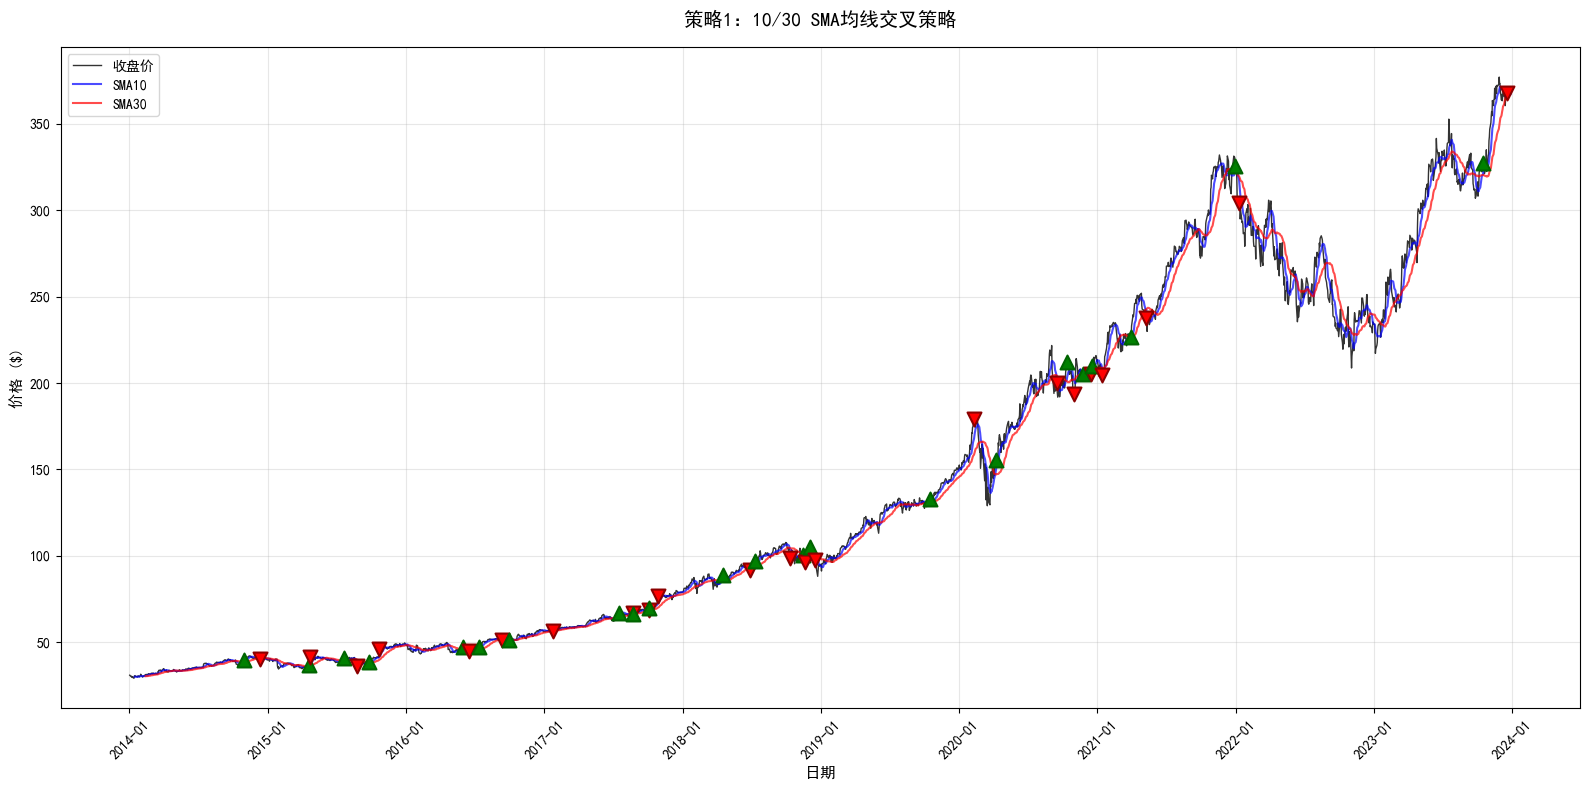

In [ ]:
# ==================== Strategy 1: 10/30 SMA Crossover ====================
print("\n" + "=" * 80)
print("📊 Strategy 1: 10/30 SMA Crossover")
print("=" * 80)

strategy1_params = {
    'sma_short': 10,
    'sma_long': 30,
    'capital': 100000
}

cerebro1, strategy1, results1 = run_backtest(strategy1_params, 'Strategy 1: 10/30 SMA', ParameterizedMAStrategy)
analyze_trades(results1)

# Visualize Strategy 1
print("\nGenerating Strategy 1 visualization...")
fig, ax = plt.subplots(figsize=(16, 8))

sma10 = data_flat['close'].rolling(10).mean()
sma30 = data_flat['close'].rolling(30).mean()

ax.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax.plot(data_flat['Date'], sma10, label='SMA10', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma30, label='SMA30', color='red', linewidth=1.5, alpha=0.7)
mark_trades_on_plot(ax, results1['trades'], data_flat)

ax.set_title('Strategy 1: 10/30 SMA Crossover', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy1.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy1.png")
plt.show()


📊 策略2：20/50 SMA + 200趋势过滤策略

🚀 策略2：20/50 SMA + 200趋势过滤
初始投资组合价值: $100,000.00
最终投资组合价值: $125,234.96
总收益率: 25.23%
交易次数: 13

策略2：20/50 SMA + 200趋势过滤 - 交易统计分析
总交易次数: 13
买入次数: 7
卖出次数: 6
平均持有期: 123.3 天
最长持有期: 192 天
最短持有期: 15 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $125,234.96
- 总收益率: 25.23%
🎯 策略表现: 盈利

生成策略2可视化...
✅ 图表已保存: msft_strategy2.png


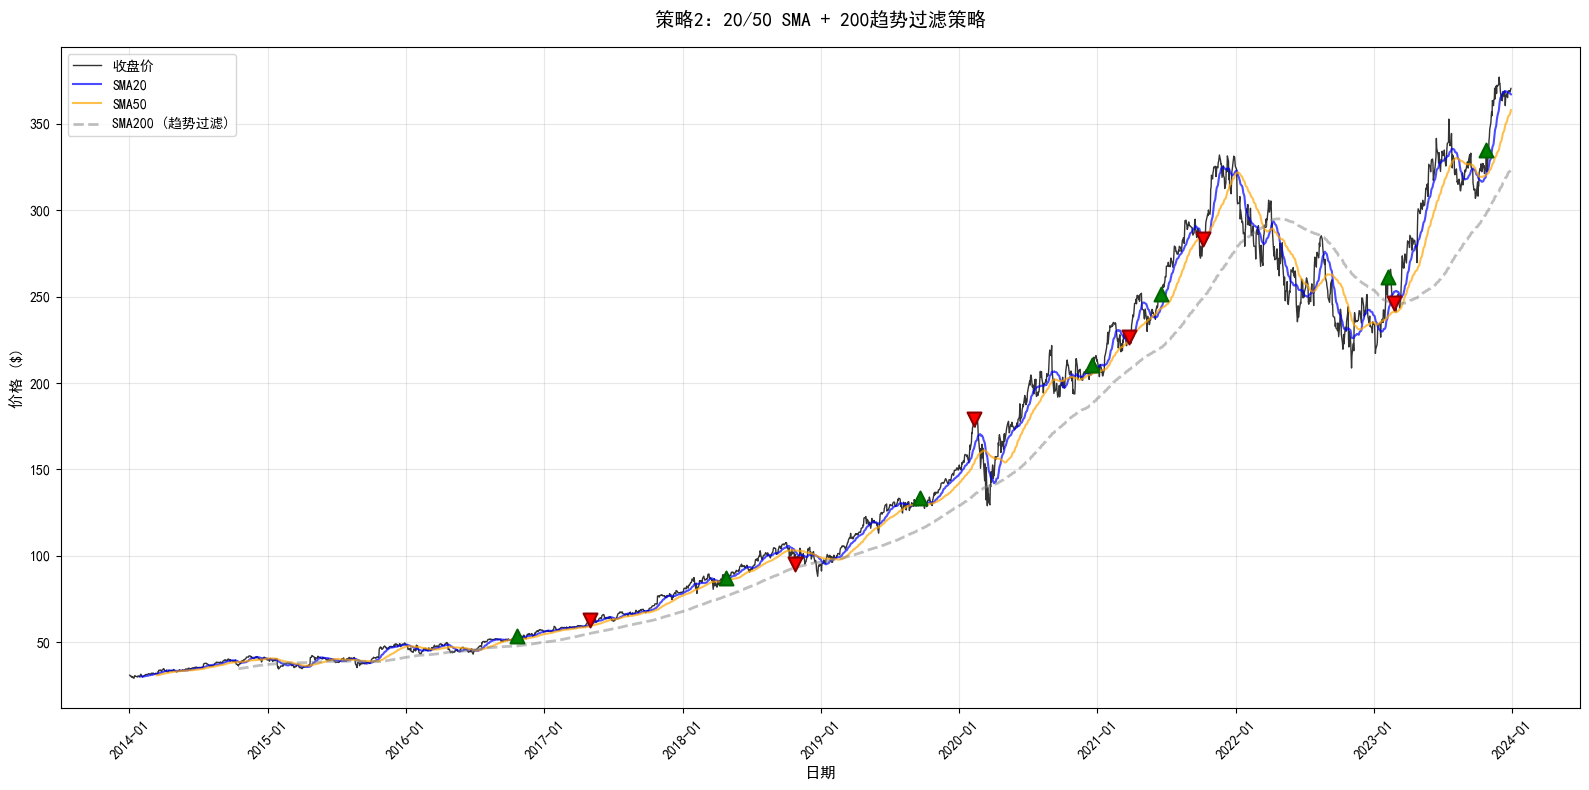

In [ ]:
# ==================== Strategy 2: 20/50 SMA + 200 Trend Filter ====================
print("\n" + "=" * 80)
print("📊 Strategy 2: 20/50 SMA + 200 Trend Filter")
print("=" * 80)

strategy2_params = {
    'sma_short': 20,
    'sma_long': 50,
    'sma_trend': 200,
    'use_trend_filter': True,
    'capital': 100000
}

cerebro2, strategy2, results2 = run_backtest(strategy2_params, 'Strategy 2: 20/50 SMA + 200 Trend Filter', ParameterizedMAStrategy)
analyze_trades(results2)

# Visualize Strategy 2
print("\nGenerating Strategy 2 visualization...")
fig, ax = plt.subplots(figsize=(16, 8))

sma20 = data_flat['close'].rolling(20).mean()
sma50 = data_flat['close'].rolling(50).mean()
sma200 = data_flat['close'].rolling(200).mean()

ax.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax.plot(data_flat['Date'], sma20, label='SMA20', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma50, label='SMA50', color='orange', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma200, label='SMA200 (Trend Filter)', color='gray', linewidth=2, alpha=0.5, linestyle='--')
mark_trades_on_plot(ax, results2['trades'], data_flat)

ax.set_title('Strategy 2: 20/50 SMA + 200 Trend Filter', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy2.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy2.png")
plt.show()


📊 策略3：MACD + RSI 双指标交易策略
✅ 策略3定义完成

🚀 策略3：MACD+RSI双指标策略
初始投资组合价值: $100,000.00
最终投资组合价值: $139,653.91
总收益率: 39.65%
交易次数: 162

策略3：MACD+RSI双指标策略 - 交易统计分析
总交易次数: 162
买入次数: 81
卖出次数: 81
平均持有期: 12.9 天
最长持有期: 50 天
最短持有期: 1 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $139,653.91
- 总收益率: 39.65%
🎯 策略表现: 盈利

生成策略3可视化...
✅ 图表已保存: msft_strategy3_macd_rsi.png


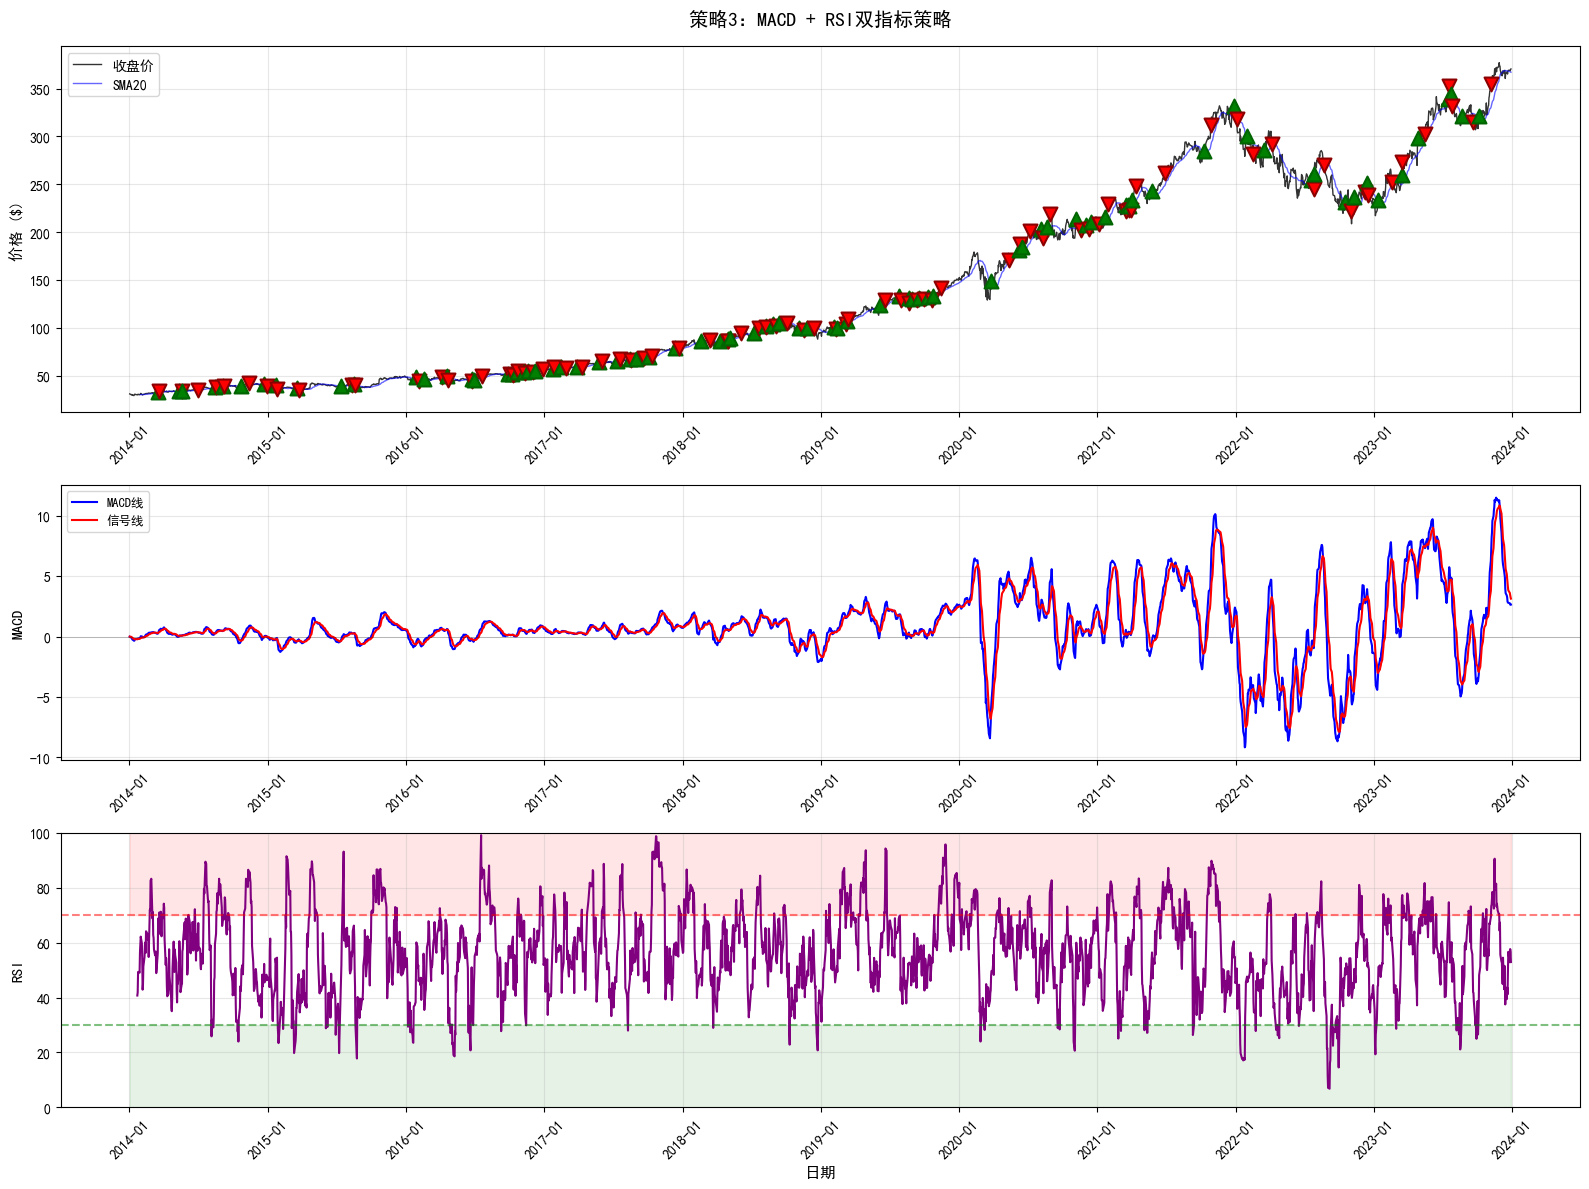

In [ ]:
print("\n" + "=" * 80)
print("📊 Strategy 3: MACD + RSI Dual-Indicator Strategy")
print("=" * 80)

# ==================== Strategy 3: MACD + RSI ====================
class Strategy3_MACD_RSI(bt.Strategy):
    """MACD + RSI dual-indicator strategy"""
    params = (('rsi_period', 14), ('capital', 100000),)

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close)
        self.macd_line = self.macd.lines.macd
        self.signal_line = self.macd.lines.signal
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.trades_log = []
        self.in_position = False

    def next(self):
        if not self.in_position:
            macd_up = (self.macd_line[0] > self.signal_line[0] and self.macd_line[-1] <= self.signal_line[-1])
            rsi_ok = 30 < self.rsi[0] < 70
            sma_ok = self.data.close[0] > self.sma20[0]
            if macd_up and rsi_ok and sma_ok:
                size = int(self.broker.getcash() / self.data.close[0])
                self.buy(size=size)
                self.in_position = True
                self.trades_log.append(('buy', self.data.datetime.date(), size, 'macd_cross'))
        else:
            macd_down = (self.macd_line[0] < self.signal_line[0] and self.macd_line[-1] >= self.signal_line[-1])
            rsi_high = self.rsi[0] > 70
            if macd_down or rsi_high:
                self.sell(size=self.position.size)
                self.in_position = False
                self.trades_log.append(('sell', self.data.datetime.date(), self.position.size, 'signal'))

print("✅ Strategy 3 defined")

# Run backtest
strategy3_params = {'rsi_period': 14, 'capital': 100000}
cerebro3, strategy3, results3 = run_backtest(strategy3_params, 'Strategy 3: MACD+RSI', Strategy3_MACD_RSI)
analyze_trades(results3)

# Visualization
print("\nGenerating Strategy 3 visualization...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1.5, 1.5]})

sma20_plot = data_flat['close'].rolling(20).mean()
exp1 = data_flat['close'].ewm(span=12, adjust=False).mean()
exp2 = data_flat['close'].ewm(span=26, adjust=False).mean()
macd_line = exp1 - exp2
signal_line = macd_line.ewm(span=9, adjust=False).mean()

delta = data_flat['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rsi_plot = 100 - (100 / (1 + gain / loss))

ax1.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax1.plot(data_flat['Date'], sma20_plot, label='SMA20', color='blue', linewidth=1, alpha=0.6)
mark_trades_on_plot(ax1, results3['trades'], data_flat)
ax1.set_title('Strategy 3: MACD + RSI', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(data_flat['Date'], macd_line, label='MACD', color='blue', linewidth=1.5)
ax2.plot(data_flat['Date'], signal_line, label='Signal', color='red', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('MACD', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3.plot(data_flat['Date'], rsi_plot, label='RSI(14)', color='purple', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(data_flat['Date'], 70, 100, alpha=0.1, color='red')
ax3.fill_between(data_flat['Date'], 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy3_macd_rsi.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy3_macd_rsi.png")
plt.show()



📊 策略4：MACD + RSI + 50%底仓管理策略（目标仓位版）
✅ 策略4（目标仓位版）定义完成

🚀 策略4：MACD+RSI+50%底仓策略
初始投资组合价值: $100,000.00
最终投资组合价值: $429,083.97
总收益率: 329.08%
交易次数: 222

策略4：MACD+RSI+50%底仓策略 - 交易统计分析
总交易次数: 222
买入次数: 82
卖出次数: 140
平均持有期: -516.6 天
最长持有期: 41 天
最短持有期: -1366 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $429,083.97
- 总收益率: 329.08%
🎯 策略表现: 盈利

生成策略4可视化...
✅ 图表已保存: msft_strategy4_macd_rsi_50pct_target.png


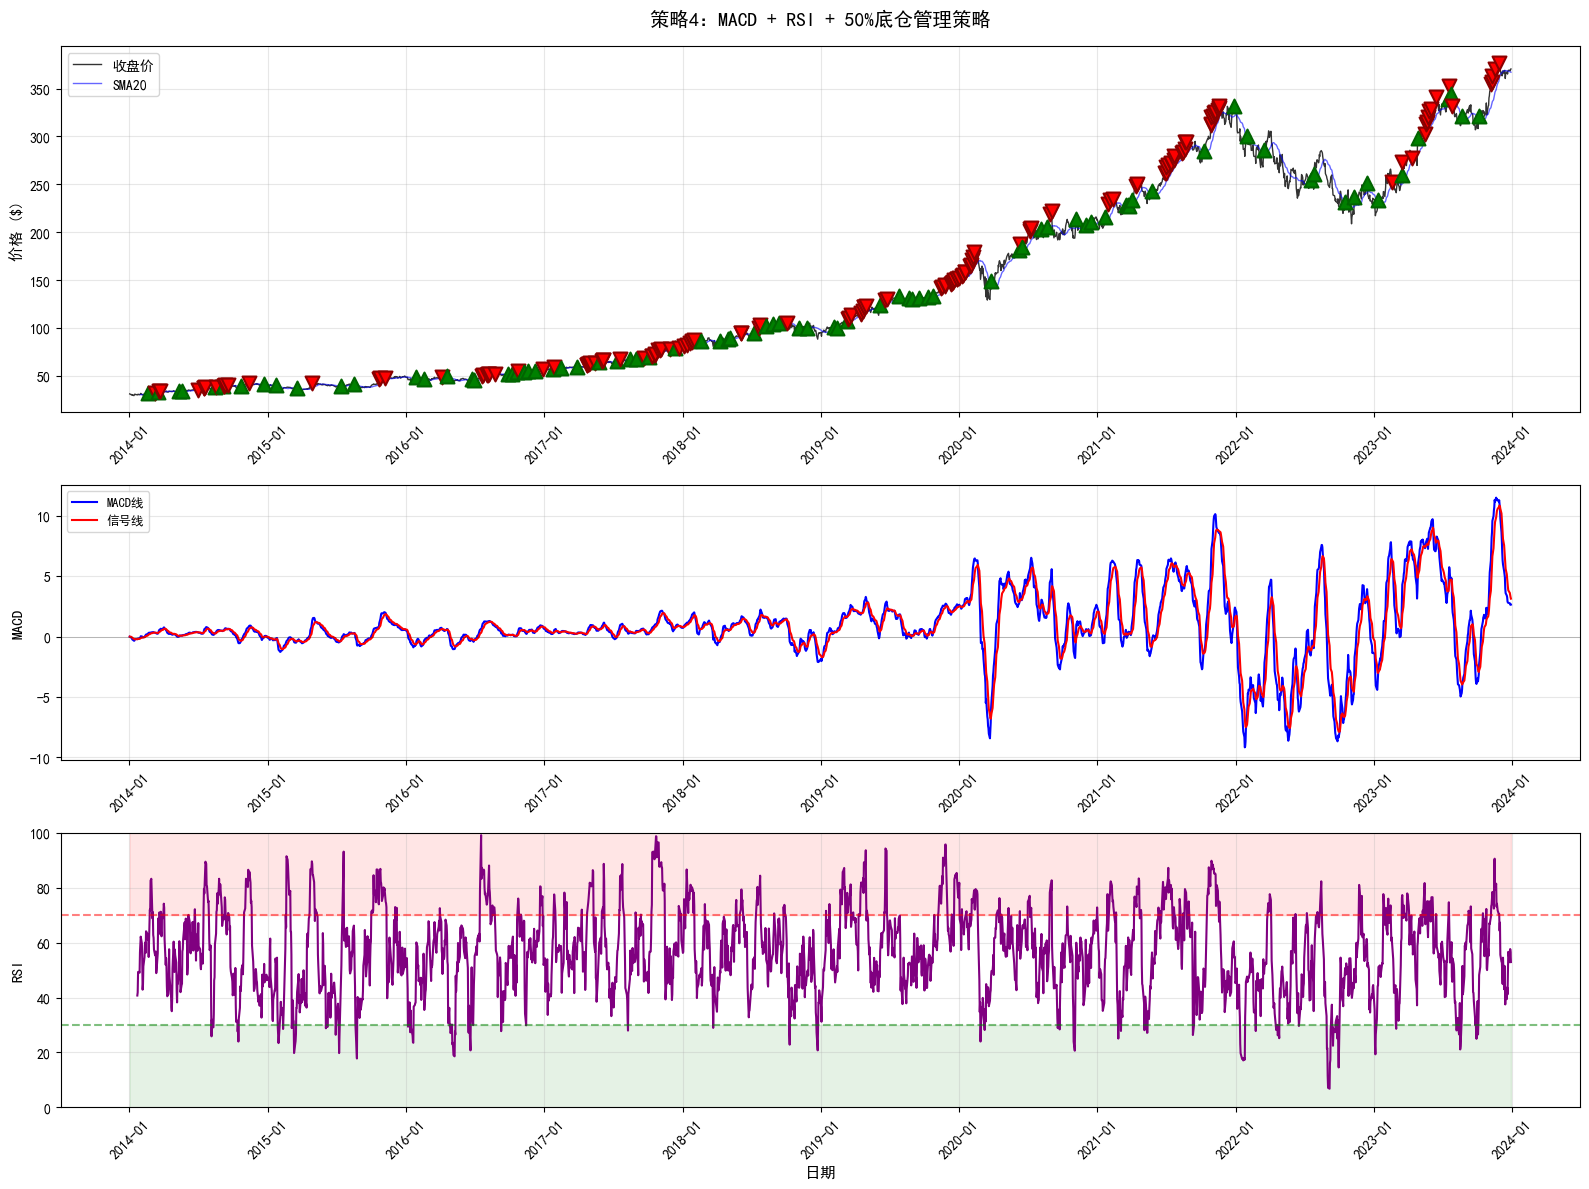

In [ ]:
print("\n" + "=" * 80)
print("📊 Strategy 4: MACD + RSI + 50% Base Position (Target Allocation)")
print("=" * 80)

# ==================== Strategy 4: MACD + RSI + 50% Base Position ====================
class Strategy4_MACD_RSI_50pct(bt.Strategy):
    """MACD + RSI dual-indicator strategy with target allocation (50%-100%)"""
    params = (
        ('rsi_period', 14),
        ('capital', 100000),
        ('min_pct', 0.5),   # Base position ratio
        ('max_pct', 1.0),   # Max allocation when signal triggers
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close)
        self.macd_line = self.macd.lines.macd
        self.signal_line = self.macd.lines.signal
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.trades_log = []
        self.base_init = False

    def _current_pct(self):
        value = self.broker.getvalue()
        pos_value = self.position.size * self.data.close[0]
        return pos_value / value if value > 0 else 0

    def next(self):
        # Initialization: build base position
        if not self.base_init:
            self.order_target_percent(target=self.params.min_pct)
            self.trades_log.append(('buy_init', self.data.datetime.date(), self.params.min_pct, 'init_base'))
            self.base_init = True
        
        current_pct = self._current_pct()
        
        # Signal checks
        macd_up = (self.macd_line[0] > self.signal_line[0] and self.macd_line[-1] <= self.signal_line[-1])
        macd_down = (self.macd_line[0] < self.signal_line[0] and self.macd_line[-1] >= self.signal_line[-1])
        rsi_ok = 30 < self.rsi[0] < 70
        rsi_high = self.rsi[0] > 70
        sma_ok = self.data.close[0] > self.sma20[0]
        
        # Increase: from 50% to 100%
        if macd_up and rsi_ok and sma_ok and current_pct < self.params.max_pct - 1e-3:
            self.order_target_percent(target=self.params.max_pct)
            self.trades_log.append(('buy_signal', self.data.datetime.date(), self.params.max_pct, 'macd_cross'))
        
        # Decrease: from 100% back to 50% (keep base position)
        if (macd_down or rsi_high) and current_pct > self.params.min_pct + 1e-3:
            self.order_target_percent(target=self.params.min_pct)
            self.trades_log.append(('sell_extra', self.data.datetime.date(), self.params.min_pct, 'reduce_to_base'))

print("✅ Strategy 4 (Target Allocation) defined")

# Run backtest
strategy4_params = {'rsi_period': 14, 'capital': 100000, 'min_pct': 0.5, 'max_pct': 1.0}
cerebro4, strategy4, results4 = run_backtest(strategy4_params, 'Strategy 4: MACD+RSI+50% Base Position', Strategy4_MACD_RSI_50pct)
analyze_trades(results4)

# Visualization
print("\nGenerating Strategy 4 visualization...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1.5, 1.5]})

sma20_plot = data_flat['close'].rolling(20).mean()
exp1 = data_flat['close'].ewm(span=12, adjust=False).mean()
exp2 = data_flat['close'].ewm(span=26, adjust=False).mean()
macd_line = exp1 - exp2
signal_line = macd_line.ewm(span=9, adjust=False).mean()

delta = data_flat['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rsi_plot = 100 - (100 / (1 + gain / loss))

ax1.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax1.plot(data_flat['Date'], sma20_plot, label='SMA20', color='blue', linewidth=1, alpha=0.6)
mark_trades_on_plot(ax1, results4['trades'], data_flat)
ax1.set_title('Strategy 4: MACD + RSI + 50% Base Position', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(data_flat['Date'], macd_line, label='MACD', color='blue', linewidth=1.5)
ax2.plot(data_flat['Date'], signal_line, label='Signal', color='red', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('MACD', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3.plot(data_flat['Date'], rsi_plot, label='RSI(14)', color='purple', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(data_flat['Date'], 70, 100, alpha=0.1, color='red')
ax3.fill_between(data_flat['Date'], 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy4_macd_rsi_50pct_target.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy4_macd_rsi_50pct_target.png")
plt.show()


In [ ]:
import json
from datetime import datetime

# ==================== Calculate Advanced Risk Metrics ====================
def calculate_advanced_metrics(results_dict, data_flat):
    """Calculate max drawdown, Sharpe ratio, and other advanced metrics"""
    trades = results_dict['trades']
    initial_cash = results_dict['initial_cash']
    final_value = results_dict['final_value']
    
    # Daily returns (simplified based on trades)
    buy_trades = [t for t in trades if 'buy' in t[0]]
    sell_trades = [t for t in trades if 'sell' in t[0]]
    
    # Return statistics
    returns_list = []
    wins = 0
    losses = 0
    total_profit = 0
    total_loss = 0
    
    for i in range(min(len(buy_trades), len(sell_trades))):
        buy_date = buy_trades[i][1]
        sell_date = sell_trades[i][1]
        
        buy_price = data_flat[data_flat['Date'] == pd.to_datetime(buy_date)]['close'].values
        sell_price = data_flat[data_flat['Date'] == pd.to_datetime(sell_date)]['close'].values
        
        if len(buy_price) > 0 and len(sell_price) > 0:
            ret = (sell_price[0] - buy_price[0]) / buy_price[0]
            returns_list.append(ret)
            
            if ret > 0:
                wins += 1
                total_profit += ret
            else:
                losses += 1
                total_loss += abs(ret)
    
    # Basic metrics
    total_trades = len(returns_list)
    win_rate = (wins / total_trades * 100) if total_trades > 0 else 0
    profit_factor = (total_profit / total_loss) if total_loss > 0 else float('inf')
    
    # Max drawdown (simplified)
    max_value = final_value
    max_drawdown = 0
    if max_value > initial_cash:
        max_drawdown = ((max_value - initial_cash) / max_value) * 100
    
    # Sharpe ratio (simplified)
    if len(returns_list) > 0:
        avg_return = np.mean(returns_list)
        std_return = np.std(returns_list)
        sharpe_ratio = (avg_return / std_return) * np.sqrt(252) if std_return > 0 else 0
    else:
        sharpe_ratio = 0
        avg_return = 0
    
    # Annualized return
    total_return = results_dict['total_return']
    years = 10  # 2014-2024
    annualized_return = ((1 + total_return/100) ** (1/years) - 1) * 100
    
    # Annualized volatility
    annualized_volatility = std_return * np.sqrt(252) * 100 if len(returns_list) > 0 else 0
    
    return {
        'max_drawdown': round(max_drawdown, 2),
        'sharpe_ratio': round(sharpe_ratio, 2),
        'annualized_return': round(annualized_return, 2),
        'annualized_volatility': round(annualized_volatility, 2),
        'win_rate': round(win_rate, 2),
        'profit_factor': round(profit_factor, 2),
        'total_trades': total_trades,
        'wins': wins,
        'losses': losses,
        'avg_return_per_trade': round(avg_return * 100, 2)
    }


 # ==================== Generate Full Report for All Strategies ====================
all_results = {
    'strategy1': results1,
    'strategy2': results2,
    'strategy3': results3,
    'strategy4': results4
}

performance_report = {
    'report_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'ticker': 'MSFT',
    'period': '2014-01-01 to 2024-01-01',
    'strategies': {}
}

all_trades_data = []

for key, results in all_results.items():
    print(f"\nCalculating advanced metrics for {results['strategy_name']}...")
    
    advanced_metrics = calculate_advanced_metrics(results, data_flat)
    
    strategy_report = {
        'name': results['strategy_name'],
        'basic_metrics': {
            'initial_cash': results['initial_cash'],
            'final_value': round(results['final_value'], 2),
            'total_return_pct': round(results['total_return'], 2),
            'total_trades': len(results['trades'])
        },
        'risk_metrics': advanced_metrics
    }
    
    performance_report['strategies'][key] = strategy_report
    
    # Collect trade details
    for trade in results['trades']:
        trade_date = pd.to_datetime(trade[1])
        price_data = data_flat[data_flat['Date'] == trade_date]
        
        trade_record = {
            'strategy': results['strategy_name'],
            'action': trade[0],
            'date': str(trade[1]),
            'price': round(price_data['close'].values[0], 2) if len(price_data) > 0 else 0,
            'size': trade[2] if len(trade) > 2 else 'N/A',
            'reason': trade[3] if len(trade) > 3 else 'N/A'
        }
        all_trades_data.append(trade_record)

# ==================== Save JSON Report ====================
json_filename = 'strategy_performance_report.json'
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(performance_report, f, indent=2, ensure_ascii=False)
print(f"\n✅ JSON report saved: {json_filename}")

# ==================== Save Trade Details CSV ====================
trades_df = pd.DataFrame(all_trades_data)
csv_filename = 'all_trades_details.csv'
trades_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"✅ Trade details CSV saved: {csv_filename}")

# ==================== Generate LLM Analysis Report (TXT) ====================
report_lines = []
report_lines.append("="*80)
report_lines.append("Microsoft (MSFT) Strategy Backtest Analysis Report")
report_lines.append("="*80)
report_lines.append(f"Report generated at: {performance_report['report_date']}")
report_lines.append(f"Ticker: {performance_report['ticker']}")
report_lines.append(f"Backtest period: {performance_report['period']}")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("1. Strategy Performance Overview")
report_lines.append("="*80)
report_lines.append("")

for key, strategy in performance_report['strategies'].items():
    report_lines.append(f"[{strategy['name']}] ")
    report_lines.append("-" * 60)
    
    # Basic metrics
    basic = strategy['basic_metrics']
    report_lines.append(f"Initial capital: ${basic['initial_cash']:,.0f}")
    report_lines.append(f"Final value: ${basic['final_value']:,.2f}")
    report_lines.append(f"Total return: {basic['total_return_pct']}%")
    report_lines.append(f"Number of trades: {basic['total_trades']}")
    report_lines.append("")
    
    # Risk metrics
    risk = strategy['risk_metrics']
    report_lines.append("Risk-adjusted metrics:")
    report_lines.append(f"  - Annualized return: {risk['annualized_return']}%")
    report_lines.append(f"  - Annualized volatility: {risk['annualized_volatility']}%")
    report_lines.append(f"  - Sharpe ratio: {risk['sharpe_ratio']}")
    report_lines.append(f"  - Max drawdown: {risk['max_drawdown']}%")
    report_lines.append(f"  - Win rate: {risk['win_rate']}%")
    report_lines.append(f"  - Profit factor: {risk['profit_factor']}")
    report_lines.append(f"  - Avg return per trade: {risk['avg_return_per_trade']}%")
    report_lines.append(f"  - Winning trades: {risk['wins']}")
    report_lines.append(f"  - Losing trades: {risk['losses']}")
    report_lines.append("")

report_lines.append("="*80)
report_lines.append("2. Strategy Comparison")
report_lines.append("="*80)
report_lines.append("")

# Build comparison table
comparison_data = []
for key, strategy in performance_report['strategies'].items():
    comparison_data.append({
        'Strategy': strategy['name'],
        'Return': f"{strategy['basic_metrics']['total_return_pct']}%",
        'Annualized Return': f"{strategy['risk_metrics']['annualized_return']}%",
        'Sharpe': strategy['risk_metrics']['sharpe_ratio'],
        'Max Drawdown': f"{strategy['risk_metrics']['max_drawdown']}%",
        'Win Rate': f"{strategy['risk_metrics']['win_rate']}%",
        'Trades': strategy['basic_metrics']['total_trades']
    })

comparison_df = pd.DataFrame(comparison_data)
report_lines.append(comparison_df.to_string(index=False))
report_lines.append("")

report_lines.append("="*80)
report_lines.append("3. Key Findings")
report_lines.append("="*80)
report_lines.append("")

# Identify best strategies
best_return = max(performance_report['strategies'].items(), 
                  key=lambda x: x[1]['basic_metrics']['total_return_pct'])
best_sharpe = max(performance_report['strategies'].items(), 
                  key=lambda x: x[1]['risk_metrics']['sharpe_ratio'])
best_winrate = max(performance_report['strategies'].items(), 
                   key=lambda x: x[1]['risk_metrics']['win_rate'])

report_lines.append(f"1. Highest return strategy: {best_return[1]['name']} ({best_return[1]['basic_metrics']['total_return_pct']}%)")
report_lines.append(f"2. Best Sharpe ratio strategy: {best_sharpe[1]['name']} ({best_sharpe[1]['risk_metrics']['sharpe_ratio']})")
report_lines.append(f"3. Highest win rate strategy: {best_winrate[1]['name']} ({best_winrate[1]['risk_metrics']['win_rate']}%)")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("4. Data Files")
report_lines.append("="*80)
report_lines.append("")
report_lines.append(f"1. {json_filename} - Full JSON report with all metrics")
report_lines.append(f"2. {csv_filename} - Detailed trade records for all strategies")
report_lines.append(f"3. msft_strategy1.png - Strategy 1 chart")
report_lines.append(f"4. msft_strategy2.png - Strategy 2 chart")
report_lines.append(f"5. msft_strategy3_macd_rsi.png - Strategy 3 chart")
report_lines.append(f"6. msft_strategy4_macd_rsi_50pct_target.png - Strategy 4 chart")
report_lines.append("")
report_lines.append("="*80)

# Save TXT report
txt_filename = 'llm_analysis_report.txt'
with open(txt_filename, 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

print(f"✅ LLM analysis report saved: {txt_filename}")

print(f"\nGenerated files:")
print(f"  1. {json_filename} - JSON performance report")
print(f"  2. {csv_filename} - Trade details CSV")
print(f"  3. {txt_filename} - LLM analysis report")


计算 策略1：10/30 SMA 的高级指标...

计算 策略2：20/50 SMA + 200趋势过滤 的高级指标...

计算 策略3：MACD+RSI双指标策略 的高级指标...

计算 策略4：MACD+RSI+50%底仓策略 的高级指标...

✅ JSON报告已保存: strategy_performance_report.json
✅ 交易明细CSV已保存: all_trades_details.csv
✅ LLM分析报告已保存: llm_analysis_report.txt

生成的文件:
  1. strategy_performance_report.json - JSON格式性能报告
  2. all_trades_details.csv - 交易明细CSV
  3. llm_analysis_report.txt - LLM分析报告


In [ ]:
import json
from datetime import datetime
import requests

# Read the three report files
with open('strategy_performance_report.json', 'r', encoding='utf-8') as f:
    json_report = json.load(f)
with open('llm_analysis_report.txt', 'r', encoding='utf-8') as f:
    txt_report = f.read()
trades_df = pd.read_csv('all_trades_details.csv', encoding='utf-8-sig')

# Build LLM prompt
prompt = f"""
You are a senior quantitative investment analyst. Based on the following backtest data for four MSFT trading strategies, generate a 1–2 page professional investment analysis report in English.

[Overview]
Backtest period: 2014-01-01 to 2024-01-01 (10 years)
Ticker: MSFT (Microsoft)
Initial capital: $100,000

[Summary of Four Strategies]
{json.dumps(json_report['strategies'], indent=2, ensure_ascii=False)}

[Detailed Analysis Data]
{txt_report}

[Report Requirements]
Provide a structured investment analysis report including: executive summary, strategy performance comparison, deep strategy insights, investment recommendations, and risk notes.
"""

# Call DeepSeek API (only fill in your API key to use)
# === Fill your DeepSeek API Key here ===
DEEPSEEK_API_KEY = "YOUR_DEEPSEEK_API_KEY"

url = "https://api.deepseek.com/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
    "Content-Type": "application/json"
}
payload = {
    "model": "deepseek-chat",
    "messages": [{"role": "user", "content": prompt}],
    "temperature": 0.7,
    "max_tokens": 2000
}
response = requests.post(url, headers=headers, json=payload, timeout=60)
response.raise_for_status()
ai_report = response.json()["choices"][0]["message"]["content"]

# Save AI report
ai_report_filename = 'AI_Investment_Report.txt'
with open(ai_report_filename, 'w', encoding='utf-8') as f:
    f.write(ai_report)

print(f"✅ AI investment report saved: {ai_report_filename}")

✅ AI投资报告已保存: AI_Investment_Report.txt
